In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline

In [2]:
df = pd.read_csv("data/train.csv")
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S
613,614,0,3,"Horgan, Mr. John",male,NaN,0,0,370377,7.7500,NaN,Q
762,763,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
580,581,1,2,"Christy, Miss. Julie Rachel",female,25.0,1,1,237789,30.0000,NaN,S
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0000,NaN,S
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S
189,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S
457,458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S


# EDA

In [3]:
profile = ProfileReport(df)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

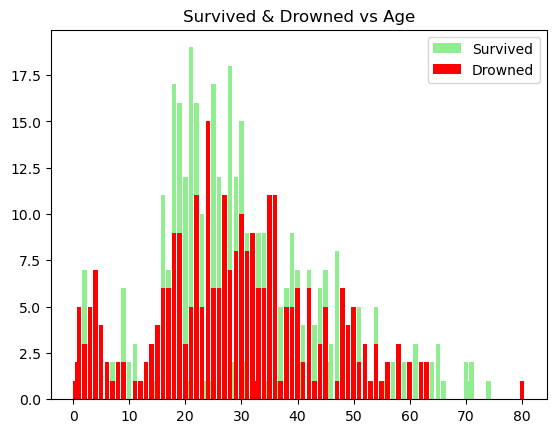

In [3]:
survival_df = pd.crosstab(df["Age"], df["Survived"])
survival_df.reset_index(inplace=True)
survival_df = pd.DataFrame(np.array(survival_df), columns=["Age", "Survived", "Drowned"])

fig, ax = plt.subplots()
ax.bar(survival_df["Age"], survival_df["Survived"], label="Survived", color="lightgreen")
ax.bar(survival_df["Age"], survival_df["Drowned"], label="Drowned", color="red");
ax.legend();
ax.set_title("Survived & Drowned vs Age");

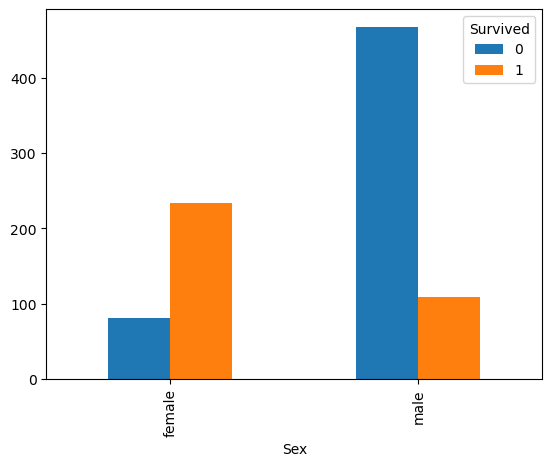

In [17]:
pd.crosstab(df["Sex"], df["Survived"]).plot(kind="bar");

### Feature Engineering

In [5]:
from functools import reduce

def names_to_titles(names):
    titles_match = [
        ('Mister', r'.*Mr\..*'), 
        ("Missus", r'.*Mrs\..*'),
        ("Miss", r'.*Miss\..*'),
        ("Ms", r'.*Ms\..*'),
        ("Master", r'.*Master\..*'),
        ("Madam", r'.*Mme\..*'),
        ("Doctor", r'.*Dr\..*'),
        ('Reverend', r'.*Rev\..*'),
        ('Colonel', r'.*Col\..*'),
        ('Miss', r'.*Mlle\..*'),
        ('Captain', r'.*Capt\..*'),
        ('Major', r'.*Major\..*'),
        ('Other', r'.*,.*'),
    ]

    titles = names.copy(deep=True)
    
    for title_match in titles_match:
        title, regex = title_match
        titles = titles.str.replace(regex, title, regex=True)
    
    return titles

In [87]:
def format_names(df):
    result_df = df.copy(deep=True)
    # Insert title and drop name column
    title = names_to_titles(result_df["Name"])

    result_df["Title"] = title
    result_df.drop("Name", axis=1, inplace=True)
    return result_df

In [ ]:
df = format_names(df)

In [7]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

# Data Preparation

In [8]:
# Dropping the ticket column, we're not going to work on it for now 
df.drop("Ticket", axis=1, inplace=True)
# Dropping the Cabin column, as mostly has missing value
df.drop("Cabin", axis=1, inplace=True)

In [9]:
X, y = df.drop("Survived", axis=1), df["Survived"]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
366,367,1,female,60.0,1,0,75.2500,C,Missus
564,565,3,female,NaN,0,0,8.0500,S,Miss
329,330,1,female,16.0,0,1,57.9792,C,Miss
417,418,2,female,18.0,0,2,13.0000,S,Miss
745,746,1,male,70.0,1,1,71.0000,S,Captain
...,...,...,...,...,...,...,...,...,...
129,130,3,male,45.0,0,0,6.9750,S,Mister
219,220,2,male,30.0,0,0,10.5000,S,Mister
581,582,1,female,39.0,1,1,110.8833,C,Missus
55,56,1,male,NaN,0,0,35.5000,S,Mister


### Filling the missing values

In [11]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Sex              0
Age            133
SibSp            0
Parch            0
Fare             0
Embarked         2
Title            0
dtype: int64

In [12]:
from sklearn.impute import SimpleImputer

def fill_missing_columns(df, column_names=["Embarked", "Age"]):
    imputer = SimpleImputer(strategy="most_frequent")
    filled_df = df.copy(deep=True)
    
    filled_df[column_names] = imputer.fit_transform(filled_df[column_names])
    return filled_df

In [13]:
filled_X_train = fill_missing_columns(X_train)
filled_X_test = fill_missing_columns(X_test)

In [15]:
filled_X_train.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

In [30]:
filled_X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
366,367,1,female,60.0,1,0,75.2500,C,Missus
564,565,3,female,22.0,0,0,8.0500,S,Miss
329,330,1,female,16.0,0,1,57.9792,C,Miss
417,418,2,female,18.0,0,2,13.0000,S,Miss
745,746,1,male,70.0,1,1,71.0000,S,Captain
...,...,...,...,...,...,...,...,...,...
129,130,3,male,45.0,0,0,6.9750,S,Mister
219,220,2,male,30.0,0,0,10.5000,S,Mister
581,582,1,female,39.0,1,1,110.8833,C,Missus
55,56,1,male,22.0,0,0,35.5000,S,Mister


In [31]:
filled_X_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
380,381,1,female,42.0,0,0,227.5250,C,Miss
451,452,3,male,24.0,1,0,19.9667,S,Mister
158,159,3,male,24.0,0,0,8.6625,S,Mister
3,4,1,female,35.0,1,0,53.1000,S,Missus
419,420,3,female,10.0,0,2,24.1500,S,Miss
...,...,...,...,...,...,...,...,...,...
121,122,3,male,24.0,0,0,8.0500,S,Mister
182,183,3,male,9.0,4,2,31.3875,S,Master
846,847,3,male,24.0,8,2,69.5500,S,Mister
208,209,3,female,16.0,0,0,7.7500,Q,Miss


### One-hot encoding categorical features

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder()
one_hot_transformer = ColumnTransformer(transformers=[
        ("one_hot", encoder, ["Embarked", "Title", "Sex"])
], remainder='passthrough')

ready_X_train = one_hot_transformer.fit_transform(filled_X_train)
ready_X_test = one_hot_transformer.transform(filled_X_test)

In [34]:
pd.DataFrame(ready_X_train)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,367,1,60.0,1,0,75.25
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,565,3,22.0,0,0,8.05
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,330,1,16.0,0,1,57.9792
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,418,2,18.0,0,2,13.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,746,1,70.0,1,1,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,130,3,45.0,0,0,6.975
708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,220,2,30.0,0,0,10.5
709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,582,1,39.0,1,1,110.8833
710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,56,1,22.0,0,0,35.5


In [35]:
pd.DataFrame(ready_X_test)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,381,1,42.0,0,0,227.525
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,452,3,24.0,1,0,19.9667
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,159,3,24.0,0,0,8.6625
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4,1,35.0,1,0,53.1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,420,3,10.0,0,2,24.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,122,3,24.0,0,0,8.05
175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,183,3,9.0,4,2,31.3875
176,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,847,3,24.0,8,2,69.55
177,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,209,3,16.0,0,0,7.75


In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

estimators = [
    ("Random Forest", RandomForestClassifier, dict(
        n_estimators=np.arange(1, 500, 100),
        criterion=["gini", "entropy", "log_loss"],
        max_depth=np.arange(1, 100, 10),
        bootstrap=[True, False],
        min_samples_split=np.arange(2, 20, 2),
        min_samples_leaf=np.arange(1, 20, 2),
    )),
    ("Log Reg", LogisticRegression, dict(
        C=np.logspace(-4, 4, 20),
        solver=["liblinear"],
        multi_class=["auto", "ovr", "multinomial"],
        n_jobs=[-1]
    )),
    ("Linear SVC", LinearSVC, dict(
        C=np.logspace(-4, 4, 20),
        loss=["hinge", "squared_hinge"],
        multi_class=["ovr", "crammer_singer"],
    )),
    ("KNeighborsClassifier", KNeighborsClassifier, dict(
        n_neighbors=np.arange(1, 500, 100),
        weights=["uniform", "distance"],
        algorithm=["auto", "ball_tree", "kd_tree", "brute"],
        n_jobs=[-1]
    ))
]


for estimator in estimators:
    name, model_class, distribution = estimator
    
    clf = RandomizedSearchCV(model_class(), distribution, random_state=42)
    
    clf.fit(ready_X_train, y_train)
    score = clf.score(ready_X_test, y_test)
    
    print("{}: {}".format(name, score))
    print(clf.best_params_)

Random Forest: 0.8603351955307262
{'n_estimators': 301, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 91, 'criterion': 'entropy', 'bootstrap': False}


C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153:

C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\linear_model\_logistic.py:1153:

Log Reg: 0.8659217877094972
{'solver': 'liblinear', 'n_jobs': -1, 'multi_class': 'auto', 'C': 4.281332398719396}


C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Piyush\anaconda3\envs\titanic-env\lib\sit

Linear SVC: 0.6815642458100558
{'multi_class': 'ovr', 'loss': 'hinge', 'C': 0.08858667904100823}


C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\neighbors\_classification.py", line 219, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "C:\Users\Piyu

KNeighborsClassifier: 0.7374301675977654
{'weights': 'uniform', 'n_neighbors': 101, 'n_jobs': -1, 'algorithm': 'ball_tree'}


C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\Piyush\anaconda3\envs\titanic-env\lib\site-packages\sklearn\neighbors\_classification.py", line 222, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\Piyush\anaconda

We're going to use Random Forest hyperparameters obtained from `RandomSearchCV` 

In [44]:
{'n_estimators': 301, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 91, 'criterion': 'entropy', 'bootstrap': False}

{'n_estimators': 301,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_depth': 91,
 'criterion': 'entropy',
 'bootstrap': False}

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=301, 
                             min_samples_split=10,
                             min_samples_leaf=3,
                             max_depth=91,
                             criterion='entropy',
                             bootstrap=False)

clf.fit(ready_X_train, y_train)
clf.score(ready_X_test, y_test)

0.8715083798882681

# Evaluation

In [48]:
y_true = y_test
y_pred = clf.predict(ready_X_test)

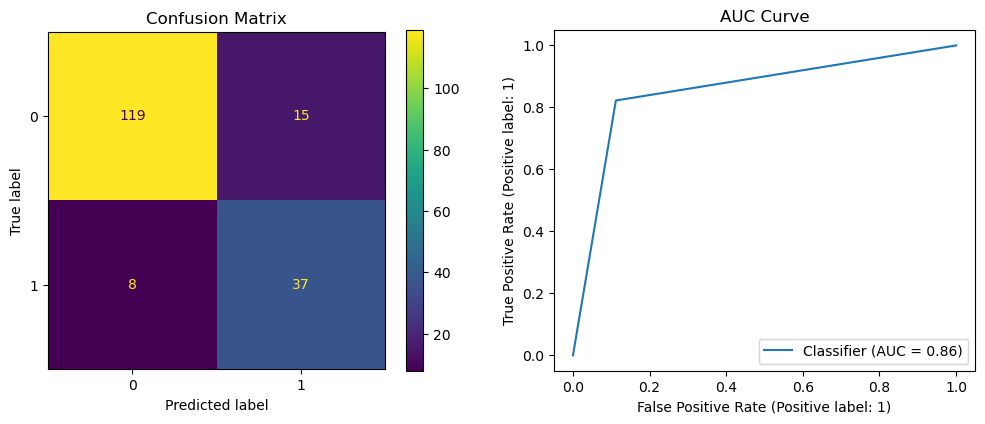

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

ax1.set_title("Confusion Matrix")
ax2.set_title("AUC Curve")

ConfusionMatrixDisplay.from_predictions(y_pred, y_true, ax=ax1);
RocCurveDisplay.from_predictions(y_pred, y_true, ax=ax2);

In [54]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       127
           1       0.82      0.71      0.76        52

    accuracy                           0.87       179
   macro avg       0.86      0.82      0.84       179
weighted avg       0.87      0.87      0.87       179



## Making predictions

In [96]:
test_df = pd.read_csv("data/test.csv")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Format Data 

In [97]:
test_df = format_names(test_df)
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,Mister
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,Missus
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,Mister
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,Mister
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,Missus
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mister
414,1306,1,female,39.0,0,0,PC 17758,108.9000,C105,C,Other
415,1307,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mister
416,1308,3,male,NaN,0,0,359309,8.0500,NaN,S,Mister


Drop columns that we don't need

In [98]:
test_df.drop(["Ticket", "Cabin"], axis=1, inplace=True)
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,Mister
1,893,3,female,47.0,1,0,7.0000,S,Missus
2,894,2,male,62.0,0,0,9.6875,Q,Mister
3,895,3,male,27.0,0,0,8.6625,S,Mister
4,896,3,female,22.0,1,1,12.2875,S,Missus
...,...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,8.0500,S,Mister
414,1306,1,female,39.0,0,0,108.9000,C,Other
415,1307,3,male,38.5,0,0,7.2500,S,Mister
416,1308,3,male,NaN,0,0,8.0500,S,Mister


### Filling missing values

In [99]:
test_df.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
Title           0
dtype: int64

In [101]:
test_df = fill_missing_columns(test_df, column_names=["Age", "Fare"])
test_df.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

### One-hot encoding

In [105]:
X = one_hot_transformer.transform(test_df)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,892.0,3.0,34.5,0.0,0.0,7.8292
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,893.0,3.0,47.0,1.0,0.0,7.0000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,894.0,2.0,62.0,0.0,0.0,9.6875
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,895.0,3.0,27.0,0.0,0.0,8.6625
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,896.0,3.0,22.0,1.0,1.0,12.2875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1305.0,3.0,21.0,0.0,0.0,8.0500
414,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1306.0,1.0,39.0,0.0,0.0,108.9000
415,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1307.0,3.0,38.5,0.0,0.0,7.2500
416,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1308.0,3.0,21.0,0.0,0.0,8.0500


In [108]:
preds = clf.predict(X)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [112]:
len(X), len(preds)

(418, 418)

## Making submission CSV

In [114]:
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": preds})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [116]:
submission.to_csv("submission.csv", index=False)